In [1]:
!pip install -q rasterio==1.3.5
!pip install -q spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 5.2 MB/s eta 0:00:00


In [2]:
# Bibliotecas
import rasterio as rio
from spectral import *
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2

In [3]:
#Função de expansão
def expansao(img, percent_ini=2, percent_fim=98):
    s = np.zeros_like(img)
    x,y = 0,255  
    w = np.percentile(img, percent_ini)
    z = np.percentile(img, percent_fim)        
    p = x + (img - w) * (y - x) / (z - w)    
    p[p<x] = x
    p[p>y] = y
    s = p
    return s

In [4]:
# Função de conversão para decibel
def linear_to_decibel(img):
    return 10*np.log10(img)

In [5]:
# Encontrando caminho das imagens
list_files = list(glob.glob("*.tif"))

In [46]:
# Leitura
with rio.open(list_files[0]) as src:
   VH = src.read(1)
with rio.open(list_files[1]) as src:
   HV = src.read(1)
with rio.open(list_files[2]) as src:
   HH = src.read(1)
with rio.open(list_files[3]) as src:
   VV = src.read(1)

S_hh = HH + 1j * cv2.blur(HH, (5,5))
S_hh_conj = HH - 1j * cv2.blur(HH, (5,5))
S_hv = HV + 1j * cv2.blur(HV, (5,5))
S_hv_conj = HV - 1j * cv2.blur(HV, (5,5))
S_vh = VH + 1j * cv2.blur(VH, (5,5))
S_vh_conj = VH - 1j * cv2.blur(VH, (5,5))
S_vv = VV + 1j * cv2.blur(VV, (5,5))
S_vv_conj = VV - 1j * cv2.blur(VV, (5,5))

In [48]:
# Calculando decomposição
Pauli1 = 0.5 * abs((S_hh - S_vv) * (S_hh_conj - S_vv_conj))
Pauli2 = 0.5 * abs((S_hv + S_vh) * (S_hv_conj + S_vh_conj))
Pauli3 = 0.5 * abs((S_hh + S_vv) * (S_hh_conj + S_vv_conj))

stack = np.dstack([Pauli1,Pauli2,Pauli3])
stack = linear_to_decibel(stack)

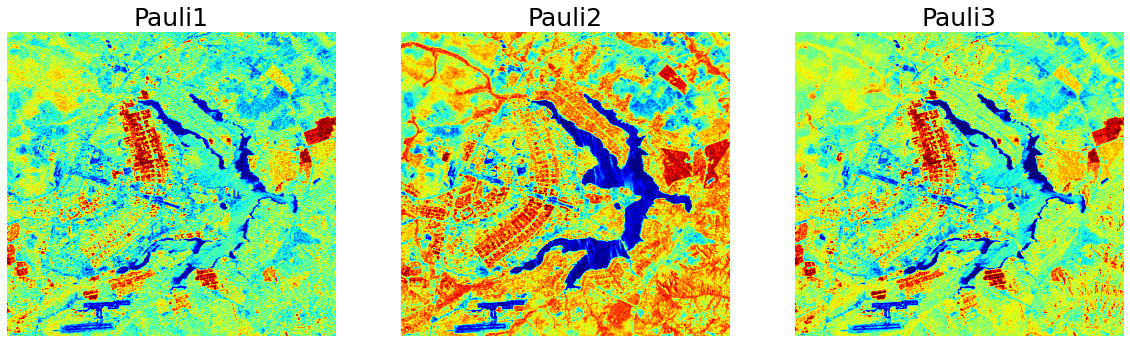

In [53]:
# Visualizando componentes
names = ['Pauli1', 'Pauli2', 'Pauli3']
fig,axes = plt.subplots(1,3,figsize=(20,10),sharex='all', sharey='all') 
axes = axes.ravel() 
for i in range(stack.shape[2]): 
  axes[i].imshow(expansao(stack[:,:,i]),cmap='jet') 
  axes[i].set_title(names[i],fontsize=25) 
  axes[i].axis('off')

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-46.51713943481445, -0.38842278718948364]
    G: [-46.82680130004883, -12.031185150146484]
    B: [-28.793230056762695, 6.574356555938721]

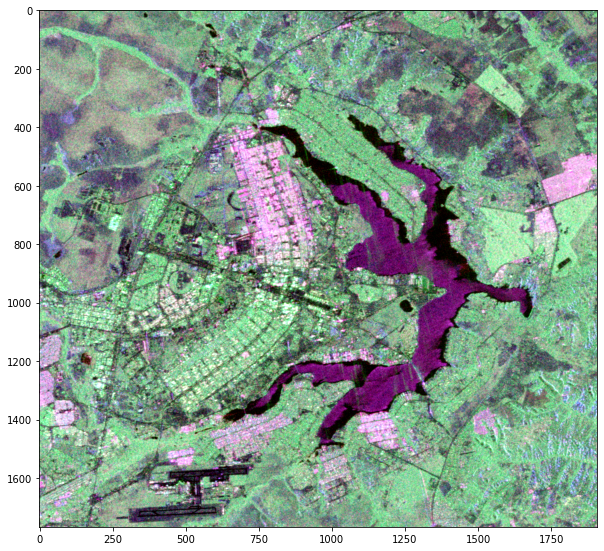

In [56]:
# Composição colorida
imshow(stack, stretch=(0.02,0.98), figsize=(10,15))